In [1]:
from src.GEFConstructor import CreateGEF

import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline

from src.Tools.ModeByMode import ModeByMode, ReadMode

from src.Tools.TensorPowerSpec import PowSpecT

from src.Tools.PlotSC import PlotSensitivityCurves

In [ ]:
G = CreateGEF("Config/SchwingerGEF+beta25+Mass+KDepMix.py")
if G.GEFData==None or not(G.completed):
    G.RunGEF(100, t1=90)
    if G.GEFData==None:
        G.GEFData = "Out/NewRun.dat"
    G.SaveData()
G.Unitful()


Already Unitful


In [3]:
MbM = ModeByMode(G)
if G.ModeData==None or not(os.path.isfile(G.ModeData)):
    ks = np.exp(np.linspace(np.log(MbM.mink), np.log(MbM.maxk), 1000))
    ks, tstart = MbM.InitialKTN(ks, mode="k")
    Neval = np.arange(max(G.vals["N"]), 5, -0.1)[::-1]
    teval = CubicSpline(G.vals["N"], G.vals["t"])(Neval)
    plt.plot(tstart, ks, "b")
    plt.plot(G.vals["t"], 10**(5/2)*G.vals["kh"], "r:")
    plt.yscale("log")
    plt.show()

    Ap = []
    dAp = []
    Am = []
    dAm = []
    for i, k in enumerate(ks):
        A1, A2, A3, A4 = MbM.ComputeMode(k, tstart[i], teval=teval, rtol=1e-5)
        Ap.append(A1)
        Am.append(A3)
        dAp.append(A2)
        dAm.append(A4)
    Ap = np.array(Ap)
    Am = np.array(Am)
    dAp = np.array(dAp)
    dAm = np.array(dAm)
    if G.ModeData==None:
        G.ModeData = "Modes/NewRun.dat"
    MbM.SaveMode(teval, ks, Ap, dAp, Am, dAm, name=G.ModeData)
else:
     teval, Neval, ks, Ap, dAp, Am, dAm =  ReadMode(G.ModeData)
     Neval = np.array(list(Neval))


[61.01322827]


In [4]:
EMode = []
BMode = []
GMode = []

for i, t in enumerate(teval):
    Etmp, Btmp, Gtmp = MbM.ComputeEBGnMode(Ap[:,i], Am[:,i], dAp[:,i], dAm[:,i], t, ks)
    EMode.append(Etmp)
    BMode.append(Btmp)
    GMode.append(Gtmp)
    
EMode1 = np.array(EMode)
BMode1 = np.array(BMode)
GMode1 = np.array(GMode)

[61.01322827]


/tmp/ipykernel_160727/3144442509.py:11: RuntimeWarning: divide by zero encountered in divide
  errE = abs(ER - EMode1)/EMode1
/tmp/ipykernel_160727/3144442509.py:13: RuntimeWarning: divide by zero encountered in divide
  errB = abs(BR - BMode1)/BMode1
/tmp/ipykernel_160727/3144442509.py:15: RuntimeWarning: divide by zero encountered in divide
  errG = abs(GR - GMode1)/GMode1


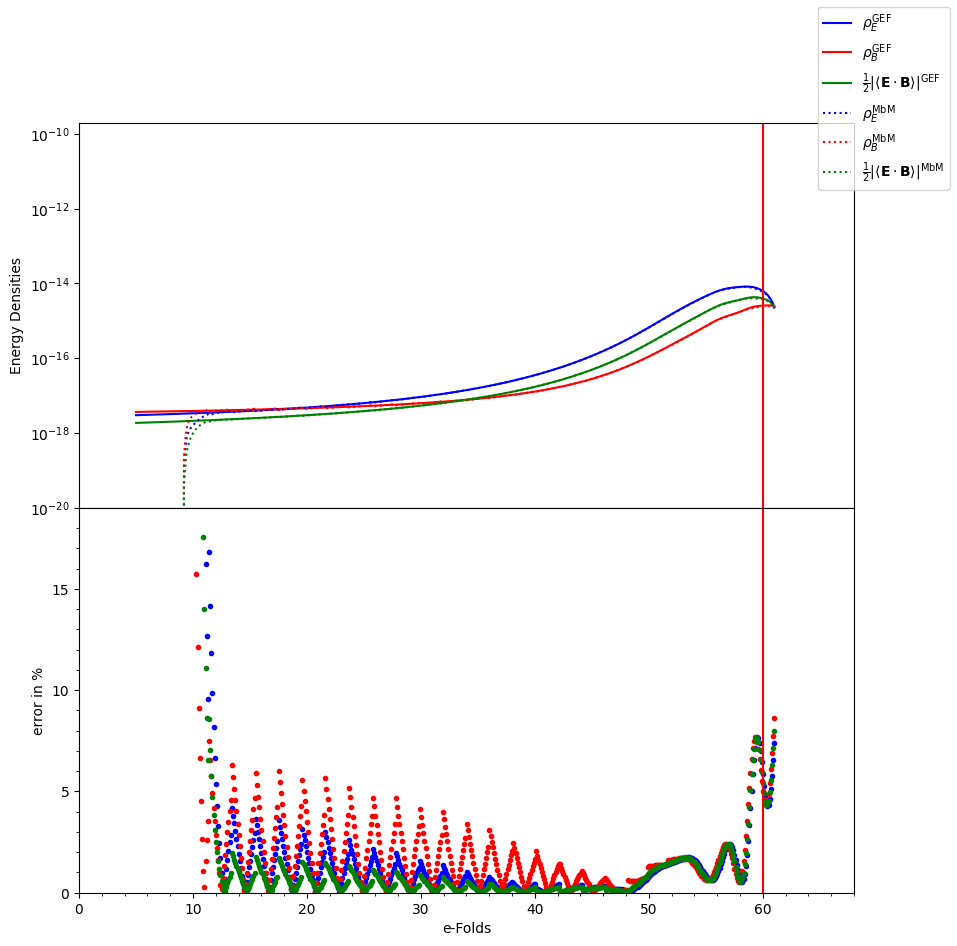

In [5]:
fig, ax = plt.subplots(2,1, figsize=(10,10), sharex=True)
ER = CubicSpline(G.vals["N"], G.vals["E"])(Neval)
BR = CubicSpline(G.vals["N"], G.vals["B"])(Neval)
GR = CubicSpline(G.vals["N"], G.vals["G"])(Neval)
NR = Neval

Nend = G.EndOfInflation()

omega = G.H0
rhoE = 0.5*ER*omega**4
errE = abs(ER - EMode1)/EMode1
rhoB = 0.5*BR*omega**4
errB = abs(BR - BMode1)/BMode1
rhoG = 0.5*abs(GR)*omega**4
errG = abs(GR - GMode1)/GMode1



ax[0].plot(NR, rhoE, "b", label=r"$\rho_E^{\mathrm{GEF}}$")
ax[0].plot(NR, rhoB, "r", label=r"$\rho_B^{\mathrm{GEF}}$")
ax[0].plot(NR, rhoG, "g", label=r"$\frac{1}{2} |\langle \mathbf{E} \cdot \mathbf{B} \rangle|^{\mathrm{GEF}}$")
ax[0].plot(NR, 0.5*EMode1*omega**4, "b:", label=r"$\rho_E^{\mathrm{MbM}}$")
ax[0].plot(NR, 0.5*BMode1*omega**4, "r:", label=r"$\rho_B^{\mathrm{MbM}}$")
ax[0].plot(NR, 0.5*abs(GMode1)*omega**4, "g:", label=r"$\frac{1}{2} |\langle \mathbf{E} \cdot \mathbf{B} \rangle|^{\mathrm{MbM}}$")


yticks = 10**(-1.*np.arange(18, 9, 2))

ax[0].set_ylim(1e-20, 2e-10)
ax[0].set_yticks(yticks)
ax[0].set_ylabel("Energy Densities")
ax[0].set_yscale("log")

ax[1].plot(NR, abs(errE*100), "b.")
ax[1].plot(NR, abs(errB*100), "r.")
ax[1].plot(NR, abs(errG*100), "g.")


yticks = np.arange(0, 20, 5)
yticksmin =  np.arange(0, 20, 1)

ax[1].set_yticks(yticks)
ax[1].set_yticks(yticksmin, minor=True)
ax[1].set_ylim(0, 19)
ax[1].set_ylabel("error in %")

xticks = np.arange(0, 70, 10)
xticksmin = np.arange(0, 70, 2)

ax[1].set_xticks(xticks)
ax[1].set_xticks(xticksmin, minor=True)
ax[1].set_xlim(0, )
ax[1].set_xlabel("e-Folds")


lines_labels = [ax[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
for a in ax:
    y=a.get_ylim()
    a.vlines(60, y[0], y[1], "r")
plt.subplots_adjust(hspace=0)
fig.legend(lines, labels)

In [6]:
P = PowSpecT(G)

[61.01322827]


In [7]:
kgrid = np.logspace(np.log10(P.mink), np.log10(P.maxk), 50)
PT = P.ComputePowSpec(kgrid, ModePath=G.ModeData)#, Nfin=60)

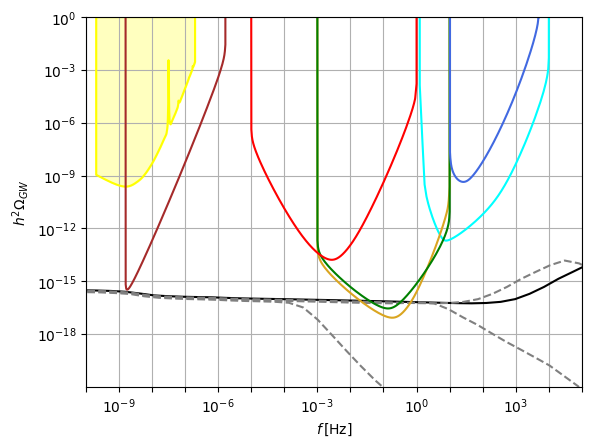

In [12]:

fig, ax = plt.subplots(1,1)

Trhs = [None, 1e12, 1e8, 1e4]
for Trh in Trhs:
    Omega, f = P.PTtoOmega(PT["tot"], kgrid, Trh=Trh)
    if Trh==None:
        ax.plot(f, Omega, "k")
    else:
        ax.plot(f, Omega, "gray", linestyle="--")

PlotSensitivityCurves(ax, ["ET", "BBO", "DECIGO", "NANOGrav", "SKA", "LISA", "HLVK"],
                       ["aqua", "goldenrod", "green", "yellow", "brown", "red", "royalblue"])

#yAxis
yticks = 10**(np.arange(-18., 3, 3))

ax.set_ylabel("$h^2 \Omega_{GW}$")
ax.set_yscale("log")
ax.set_ylim(1e-21, 1e0)
ax.set_yticks(yticks)

#xAxis
x1 = np.round(np.arange(-9, 6, 3),0)
x2 = np.round(np.arange(-10, 6, 1))

ax.set_xlabel(r"$f\,[{\rm Hz}]$")
ax.set_xscale("log")
ax.set_xlim(1e-10, 1e0)
xlabels = []
xticks = []
for x in x2:
    if x in x1:
        if x >= 0:
            xlabels.append(rf"$10^{x}$")
        else:
            xlabels.append(r"$10^{-}$" + rf"$^{abs(x)}$")
    else: xlabels.append("")
    xticks.append(10**float(x))
ax.set_xticks(xticks, xlabels)
#ax.set_xticks(xticksmin, minor=True)


ax.grid(True)

#plt.savefig("FlashingBeacon/OmegaGW_DOF.pdf")
plt.show()